## Import Python libary

In [1]:
import numpy as np
import pandas as pd
import librosa
import soundfile as sf
import sounddevice as sd
import time
import os
import re
import math
import matplotlib.pyplot as plt
import speech_recognition as sr
import random
from tensorflow import keras
from pydub import AudioSegment
from word2number import w2n
# import webrtcvad # 這個有可能需要額外下載 Microsoft C++ Build Tools 這個是用在VAD那個函數。
# import noisereduce as nr  # 需要額外的pip install torch
# import audiosegment

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Global variables

In [2]:
Speakers = ['Allen', 'Benjamin', 'Han', 'Hua', 'Jackson', 'Noah', 'Olivia', 'Patrick', 'Rain', 'Xin']
NumOfSpeakers = 10
NumOfDataOfSpeaker = [] # 儲存每個speaker的音檔數量：[72, 92, 72, 72, 98, 106, 97, 72, 72, 72]
AudioFiles = []  # 包含所有的音檔：[[(y, sr), (y, sr)......], [], []......]
DataFrame = pd.DataFrame()  # 包含所有音檔的CNN DataFrame
training_y = pd.DataFrame()
training_X = pd.DataFrame()            
validation_y = pd.DataFrame()
validation_X = pd.DataFrame()
test_data = [] # 儲存錄音後將聲音轉成音訊的numpy array
recognizer = sr.Recognizer() # 語音轉文字

## Read files
Read files from dataset and store their y and sr into AudioFiles

In [3]:
def ReadFile(AudioFiles, NumOfDataOfSpeaker):
    base_path = 'dataset'
    for name in os.listdir(base_path):
        name_path = os.path.join(base_path, name)     # name_path = dataset/name
        tmp = []
        cnt = 0
        for file_name in os.listdir(name_path):
            if file_name.endswith('.flac'):
                file_path = os.path.join(name_path, file_name)  # file_path = dataset/name/file_name

                # 判斷音檔長度，大於10秒才保留
                duration = librosa.get_duration(path=file_path)
                if duration < 10: continue
                    
                # y, sr = load_and_normalize_audio(file_path)
                y, sr = librosa.load(file_path, sr=None)
                y = y[:int(sr * 10)] 
                if(name == 'Xin'): y = y * 3.5
                if(name == 'Han'): y = y * 3
                tmp.append((y, sr))
                cnt += 1
        random.shuffle(tmp)
        NumOfDataOfSpeaker.append(cnt)
        AudioFiles.append(tmp)

ReadFile(AudioFiles, NumOfDataOfSpeaker)

## VAD and Noise reduction

##### Implement VAD algorithm

In [4]:
# # 這個可以知道音檔資料，因為vad.is_speech這個函數對音檔格式很要求，
# # Sample Rate要是8k、16k、32k
# # Channels要是單聲道
# # Sample Width也規定要是16位元
# def get_audio_info(audio_file):
#     audio_data, sample_rate = sf.read(audio_file)
#     # 獲取音訊資訊
#     sample_width = audio_data.dtype.itemsize * 8  # 計算取樣寬度（以位元表示）
#     n_channels = audio_data.shape[1] if len(audio_data.shape) > 1 else 1  # 計算通道數
#     n_frames = audio_data.shape[0]  # 計算幀數
#     # 輸出音訊資訊
#     # print(f"原音訊資訊：")
#     print(f"取樣率(Sample Rate): {sample_rate}")
#     print(f"取樣寬度(Sample Width): {sample_width}")
#     print(f"通道數(Channels): {n_channels}")
#     print(f"幀數(Frames): {n_frames}")

# # 如果Sample Rate跟Channels不對的話可以用這個轉換一下，但需要一個新的檔案來存這個修改過後的音檔
# def convert_audio(input_file, output_file, target_sample_rate=16000):
#     # 讀取音訊檔案
#     audio_data, sample_rate = sf.read(input_file)

#     # 如果音訊是雙聲道，將其轉換為單聲道
#     if audio_data.ndim > 1:
#         audio_data = audio_data.mean(axis=1)

#     # 計算重取樣後的長度
#     num_samples = round(len(audio_data) * float(target_sample_rate) / sample_rate)

#     # 執行重取樣
#     resampled_audio = resample(audio_data, num_samples)

#     # 寫入重取樣後的音訊檔案
#     sf.write(output_file, resampled_audio, target_sample_rate)


# # 這個主要的功能是吃一段音檔，然後他可以告訴你這段音檔是不是刻意錄音的
# # 如果是那種背景音她會當作是沒有錄音，但背景音也不能太大聲，比如說像是電風扇的聲音她會視作不是語音這樣
# def VAD(audio_file):

#     audio_data, sample_rate = sf.read(audio_file)

#     # 初始化 VAD
#     vad = webrtcvad.Vad()
#     vad.set_mode(3) 

#     # 轉換成 16 位元 PCM 格式
#     audio_data_pcm = (audio_data * (2 ** 15)).astype('int16')

#     # 切割為 10 毫秒片段
#     frame_duration = 10  # 毫秒
#     frame_length = int(sample_rate * (frame_duration / 1000))

#     offset = 0
#     speech_results = []
#     while offset + frame_length < len(audio_data_pcm):
#         frame = audio_data_pcm[offset:offset + frame_length]
#         is_speech = vad.is_speech(frame.tobytes(), sample_rate)
#         speech_results.append(is_speech)
#         offset += frame_length

#     # if any(speech_results):
#     #     print("此音訊檔案包含錄音")
#     # else:
#     #     print("此音訊檔案不包含錄音")
    
#     for i in range(len(speech_results)):
#         speech_results[i] = 1 if speech_results[i] else 0

#     print(f"1是有錄音的片段0沒有: {speech_results}") 

# audio_file = "dataset/Abigail/150-126107-0002.flac"
# get_audio_info(audio_file)
# VAD(audio_file)

In [5]:
# #對我們所有的 data_set 做 VAD，可以用，但會跑一陣子
# def VAD_for_folder(base_path):
#     all_results = []  # 用於存儲所有音檔的結果

#     for person in os.listdir(base_path):
#         person_path = os.path.join(base_path, person)
#         if os.path.isdir(person_path):  # 確保是資料夾
#             person_results = []  # 用於存儲這個人的音檔結果
#             for file_name in os.listdir(person_path):
#                 if file_name.endswith('.flac'):
#                     audio_file = os.path.join(person_path, file_name)
#                     audio_data, sample_rate = sf.read(audio_file)

#                     # 初始化 VAD
#                     vad = webrtcvad.Vad()
#                     vad.set_mode(3) 

#                     # 轉換成 16 位元 PCM 格式
#                     audio_data_pcm = (audio_data * (2 ** 15)).astype('int16')

#                     # 切割為 10 毫秒片段
#                     frame_duration = 10  # 毫秒
#                     frame_length = int(sample_rate * (frame_duration / 1000))

#                     offset = 0
#                     speech_results = []
#                     while offset + frame_length < len(audio_data_pcm):
#                         frame = audio_data_pcm[offset:offset + frame_length]
#                         is_speech = vad.is_speech(frame.tobytes(), sample_rate)
#                         speech_results.append(is_speech)
#                         offset += frame_length

#                     speech_results_numeric = [1 if result else 0 for result in speech_results]
#                     person_results.append(speech_results_numeric)
            
#             all_results.append(person_results)  # 將這個人的結果添加到所有結果中

#     return all_results

# # 資料夾路徑
# A_base_path = 'dataset'

# # 呼叫 VAD_for_folder 函式處理整個資料夾
# results = VAD_for_folder(A_base_path)

# # 印出所有音檔的結果
# for person_results in results:
#     for audio_results in person_results:
#         print(audio_results)  # 每個音檔的結果

##### Implement Noise reduction

In [6]:
# def NoiseReduction(y, sr, audio_channels):
#     # 進行降噪處理
#     reduced_noise = nr.reduce_noise(y, sr)

#     reduced_audio = audiosegment(
#         reduced_noise.tobytes(),
#         frame_rate=sr,
#         sample_width=5,
#         channels=audio_channels
#     )

#     # 將降噪後的音檔保存為新檔案
#     denoised_file_path = "denoised_audio.wav"
#     sf.write(denoised_file_path, reduced_audio, sr)

#     print(f"Denoised audio file saved at: {denoised_file_path}")
#     return reduced_noise

## Extract Features

##### Melspectrograms

In [4]:
def Melspectrogram(y, sr):
    # 計算梅爾頻譜圖
    melspectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    # 將梅爾頻譜圖轉換為分貝表示
    log_melspectrogram = librosa.power_to_db(melspectrogram, ref=np.max)
    return log_melspectrogram

##### MFCC coefficient

In [5]:
def MFCC(y, sr):
    # Compute MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Compute Delta and Delta-Delta features
    delta_mfcc = librosa.feature.delta(mfccs)
    delta_delta_mfcc = librosa.feature.delta(mfccs, order=2)

    # Stack the original MFCC features, Delta, and Delta-Delta features along the feature axis
    combined_features = np.concatenate([mfccs, delta_mfcc, delta_delta_mfcc], axis=0)

    return combined_features

##### Zero Crossing Rate

In [6]:
def Zero_crossing_rate(y):
    zero_crossings_rate = librosa.feature.zero_crossing_rate(y).reshape(-1)
    return zero_crossings_rate

##### Spectral Band Energy

In [7]:
def spectral_band_energy(y, sr):
    # 設定相關參數
    n_fft = 2048
    hop_size = 512
    n_mels = 13  # 通道數

    # 計算梅爾頻譜
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_size, n_mels=n_mels)

    # 計算頻譜通道能量
    mel_energy = np.sum(mel_spec, axis=0)

    # Z-score 歸一化（可選）
    mel_energy_normalized = (mel_energy - np.mean(mel_energy)) / np.std(mel_energy)
    return mel_energy_normalized

## Build DataFrame

##### CNN DataFrame

In [8]:
def BuildDataFrame():
    DataFrame = pd.DataFrame(columns=['Melspectrogram', 'Speaker']) 
    for i in range(NumOfSpeakers):
        for audio_file in AudioFiles[i]:
            data = pd.DataFrame({
                'Melspectrogram': [Melspectrogram(audio_file[0], audio_file[1])], 
                'MFCC': [MFCC(audio_file[0], audio_file[1])],
                'ZCR': [Zero_crossing_rate(audio_file[0])],
                'SBE': [spectral_band_energy(audio_file[0], audio_file[1])],
                'Speaker': i
            })
            DataFrame = pd.concat([DataFrame, data], ignore_index=True)
            
        print(f'Speaker {Speakers[i]} done')
    return DataFrame

DataFrame = BuildDataFrame()

Speaker Allen done
Speaker Benjamin done
Speaker Han done
Speaker Hua done
Speaker Jackson done
Speaker Noah done
Speaker Olivia done
Speaker Patrick done
Speaker Rain done
Speaker Xin done


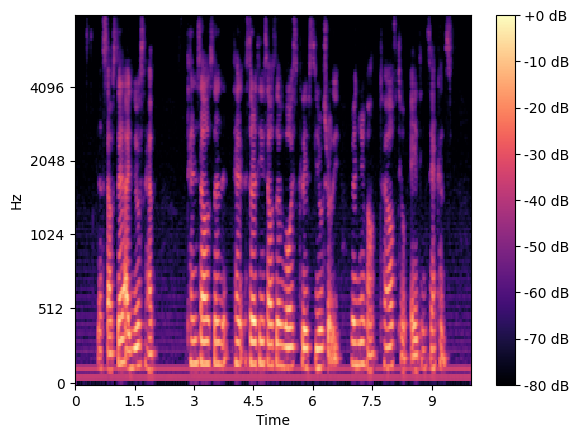

In [9]:
# 顯示梅爾頻譜圖
librosa.display.specshow(DataFrame.at[0, 'Melspectrogram'], sr=AudioFiles[0][0][1], x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.show()

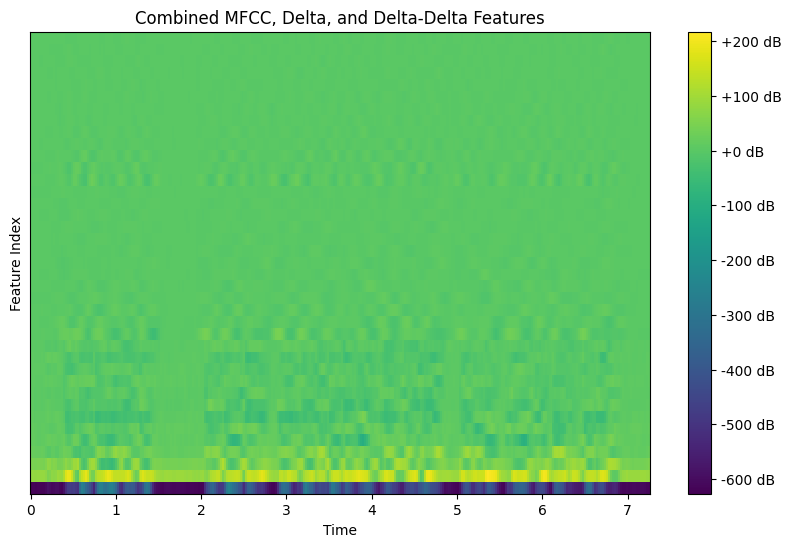

In [10]:
plt.figure(figsize=(10, 6))
librosa.display.specshow(DataFrame['MFCC'][0], x_axis='time', cmap='viridis')
plt.colorbar(format='%+2.0f dB')
plt.title('Combined MFCC, Delta, and Delta-Delta Features')
plt.xlabel('Time')
plt.ylabel('Feature Index')
plt.show()

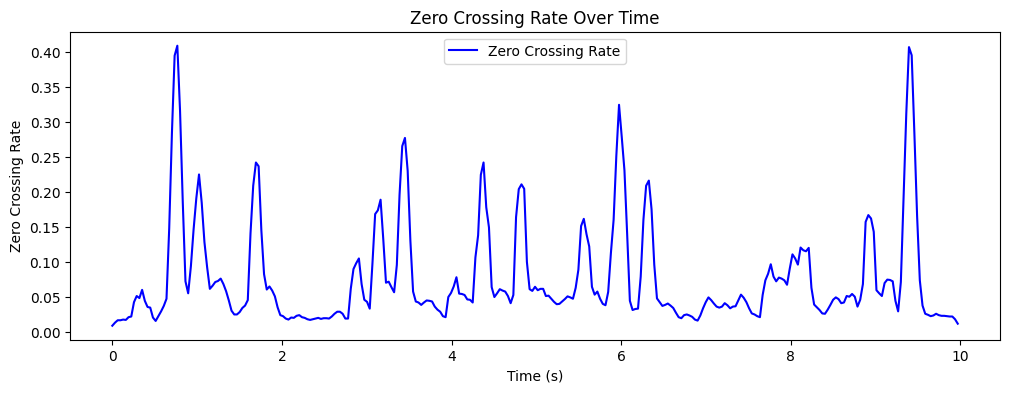

In [11]:
# Create time axis in seconds
time = np.arange(0, len(DataFrame['ZCR'][0])) * len(AudioFiles[0][0][0]) / len(DataFrame['ZCR'][0]) / AudioFiles[0][0][1]
plt.figure(figsize=(12, 4))
plt.plot(time, DataFrame['ZCR'][0], label='Zero Crossing Rate', color='b')
plt.title('Zero Crossing Rate Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Zero Crossing Rate')
plt.legend()
plt.show()

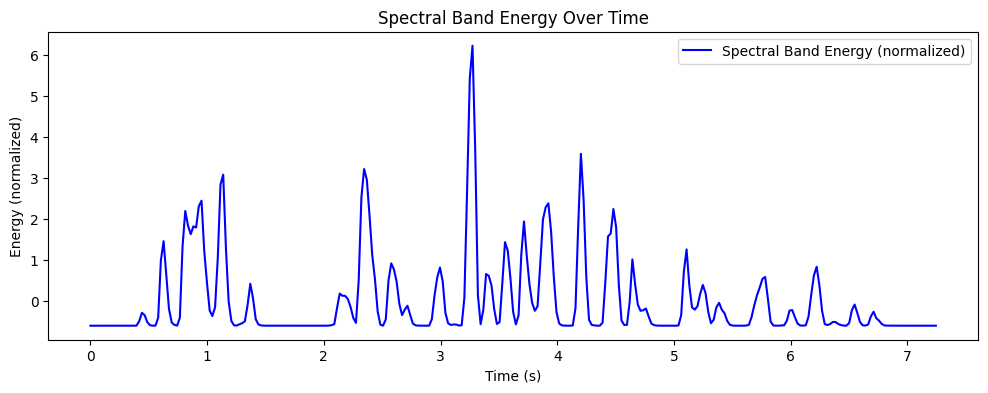

In [12]:
time = librosa.times_like(DataFrame['SBE'][0])

plt.figure(figsize=(12, 4))
plt.plot(time, DataFrame['SBE'][0], label='Spectral Band Energy (normalized)', color='b')
plt.title('Spectral Band Energy Over Time')
plt.xlabel('Time (s)')
plt.ylabel('Energy (normalized)')
plt.legend()
plt.show()

## Split data

#### split data

In [13]:
def Split_training_and_validation(y, X):
    training_y = pd.DataFrame() 
    training_X = pd.DataFrame()
    validation_y = pd.DataFrame()
    validation_X = pd.DataFrame()
    index = 0
    for i in range(NumOfSpeakers):
        split_size = math.floor(NumOfDataOfSpeaker[i] * 0.9)
        training_y   = pd.concat([training_y, y[index:index + split_size]], ignore_index=True) 
        validation_y = pd.concat([validation_y, y[index + split_size:index + NumOfDataOfSpeaker[i]]], ignore_index=True)
        training_X   = pd.concat([training_X, X[index:index + split_size]], ignore_index=True)
        validation_X = pd.concat([validation_X, X[index + split_size:index + NumOfDataOfSpeaker[i]]], ignore_index=True)
        index += NumOfDataOfSpeaker[i]
    return training_y, training_X, validation_y, validation_X

def SplitData(DataFrame):
    y = DataFrame.drop(['Melspectrogram', 'MFCC', 'ZCR', 'SBE'], axis=1)
    X = DataFrame.drop('Speaker', axis=1)
    return Split_training_and_validation(y, X)

training_y, training_X, validation_y, validation_X = SplitData(DataFrame)

##### shuffle data

In [14]:
def ShuffleData(training_y, training_X, validation_y, validation_X):
    # 將資料集個數取得
    n_train = training_y.shape[0]
    n_validation = validation_y.shape[0]
    
    # 產生訓練集的隨機排列索引
    permutation_train = list(np.random.permutation(n_train))
    shuffled_X_train = training_X.iloc[permutation_train]
    shuffled_Y_train = training_y.iloc[permutation_train]
    
    # 產生驗證集的隨機排列索引
    permutation_validation = list(np.random.permutation(n_validation))
    shuffled_X_validation = validation_X.iloc[permutation_validation]
    shuffled_Y_validation = validation_y.iloc[permutation_validation]
    
    return shuffled_Y_train, shuffled_X_train, shuffled_Y_validation, shuffled_X_validation

# 呼叫函式重新洗牌資料集
shuffled_training_y, shuffled_training_X, shuffled_validation_y, shuffled_validation_X = ShuffleData(training_y, training_X, validation_y, validation_X)

## Build Two models 

### Model

In [15]:
class Model:
    def __init__(self, training_X, validation_X, training_y, validation_y):
            # 提取梅爾頻譜圖列
            self.X_train_mel = np.stack(training_X['Melspectrogram'])
            self.X_val_mel = np.stack(validation_X['Melspectrogram'])
            # 提取MFCC列
            self.X_train_mfcc = np.stack(training_X['MFCC'])
            self.X_val_mfcc = np.stack(validation_X['MFCC'])
            # 提取 zero-crossing rate 列
            self.X_train_zcr = np.array([zcr for zcr in training_X['ZCR']])
            self.X_val_zcr = np.array([zcr for zcr in validation_X['ZCR']])
            #提取頻譜通道能量
            self.X_train_sbe = np.array([sbe for sbe in training_X['SBE']])
            self.X_val_sbe = np.array([sbe for sbe in validation_X['SBE']])
            # 提取目標列（Speaker）
            self.y_train_speaker = np.array(training_y['Speaker']).astype('int32')
            self.y_val_speaker = np.array(validation_y['Speaker']).astype('int32')

    def define_and_compile_model(self):
        # 定義mel模型
        mel_input = keras.layers.Input(shape=(128, 313))
        mel_output = keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(mel_input)
        mel_output = keras.layers.BatchNormalization()(mel_output)
        mel_output = keras.layers.MaxPooling1D(pool_size=2)(mel_output)
        mel_output = keras.layers.Flatten()(mel_output)
        mel_output = keras.layers.Dropout(0.4)(mel_output)
        mel_output = keras.layers.Dense(128, activation='relu')(mel_output)

        # 定義MFCC的模型
        mfcc_input = keras.layers.Input(shape=(39, 313))  # 設置為MFCC的形狀
        mfcc_output = keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(mfcc_input)
        mfcc_output = keras.layers.BatchNormalization()(mfcc_output)
        mfcc_output = keras.layers.MaxPooling1D(pool_size=2)(mfcc_output)
        mfcc_output = keras.layers.Flatten()(mfcc_output)
        mfcc_output = keras.layers.Dropout(0.4)(mfcc_output)
        mfcc_output = keras.layers.Dense(128, activation='relu')(mfcc_output)

        # 定義 zero-crossing rate 的模型
        zcr_input = keras.layers.Input(shape=(313,))  # Adjust the shape to match the size of your flattened ZCR feature
        zcr_output = keras.layers.Dense(64, activation='relu')(zcr_input)
        zcr_output = keras.layers.Dense(64, activation='relu')(zcr_output)  

        # 定義 SBE 的模型
        sbe_input = keras.layers.Input(shape=(313,))
        sbe_output = keras.layers.Dense(64, activation='relu')(sbe_input)  
        sbe_output = keras.layers.Dense(64, activation='relu')(sbe_output) 

        # 將四個模型的輸出串聯起來
        merged_output = keras.layers.Concatenate()([mel_output, mfcc_output, zcr_output, sbe_output])
        final_output = keras.layers.Dense(NumOfSpeakers, activation='softmax')(merged_output)

        # 創建新的模型
        self.model = keras.models.Model(inputs=[mel_input, mfcc_input, zcr_input, sbe_input], outputs=final_output)

        # 編譯模型
        self.model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    def train_model(self):
        # 訓練模型
        history = self.model.fit(
            [self.X_train_mel, self.X_train_mfcc, self.X_train_zcr, self.X_train_sbe],
            self.y_train_speaker,
            epochs=100,
            batch_size=32,
            validation_data=(
                [self.X_val_mel, self.X_val_mfcc, self.X_val_zcr, self.X_val_sbe],
                self.y_val_speaker
            )
        )

        # 獲取 history 對象
        training_loss = history.history['loss']
        training_accuracy = history.history['accuracy']
        validation_loss = history.history['val_loss']
        validation_accuracy = history.history['val_accuracy']

        # 印出最後一個 epoch 的訓練損失、訓練準確率、驗證損失和驗證準確率
        print(f"Final Training Loss: {training_loss[-1]}, Training Accuracy: {training_accuracy[-1]}")
        print(f"Final Validation Loss: {validation_loss[-1]}, Validation Accuracy: {validation_accuracy[-1]}")

    def prediction(self, mel, mfcc, zcr, sbe):
        # 將特徵轉換為模型期望的形狀
        mel = np.expand_dims(mel, axis=0)
        mfcc = np.expand_dims(mfcc, axis=0)
        zcr = np.expand_dims(zcr, axis=0)
        sbe = np.expand_dims(sbe, axis=0)

        # 使用模型進行預測
        predictions = self.model.predict([mel, mfcc, zcr, sbe], verbose=0)

        # 獲取預測的說話者 id
        predicted_speaker_id = np.argmax(predictions)

        return predicted_speaker_id
    
    def save_model(self):
        # 儲存模型
        self.model.save('Voice_Payment.h5')

    def load_model(self, filePath):
        # 載入模型
        self.model = keras.models.load_model(filePath)

    def model_summary(self):
        # 取得模型資訊
        self.model.summary()  

In [ ]:
# Method 1 : use .h5 to load trained model (不需要BuildCNNDataFrame()，只需要執行class CNN那格)
model = Model(None, None, None, None)
model.load_model('saved_model/Voice_Payment_final_version.h5')

In [16]:
# Method 2 : use dataset to train model (需要跑完整個.ipynb才能執行)
model = Model(training_X, validation_X, training_y, validation_y)
model.define_and_compile_model()
model.train_model()




Epoch 1/100


26/26 [==============================] - 2s 15ms/step - loss: 1.3163 - accuracy: 0.5688 - val_loss: 71.4422 - val_accuracy: 0.1383
Epoch 2/100
26/26 [==============================] - 0s 9ms/step - loss: 0.1808 - accuracy: 0.9415 - val_loss: 34.1127 - val_accuracy: 0.1596
Epoch 3/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0575 - accuracy: 0.9878 - val_loss: 20.1586 - val_accuracy: 0.1809
Epoch 4/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0470 - accuracy: 0.9842 - val_loss: 14.8177 - val_accuracy: 0.2660
Epoch 5/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0123 - accuracy: 1.0000 - val_loss: 6.2563 - val_accuracy: 0.3617
Epoch 6/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0099 - accuracy: 0.9988 - val_loss: 2.0802 - val_accuracy: 0.5638
Epoch 7/100
26/26 [==============================] - 0s 8ms/step - loss: 0.0078 - accuracy: 0.9988 - val_loss: 0.6077 - val_accuracy: 0.8404
Epo

##### Save model

In [28]:
model.save_model()

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Test our model

#### Recording

In [17]:
def Recording():
    # 錄音參數設定
    duration = 10  # 錄音秒數
    sample_rate = 16000  # 取樣率(samples per second)

    print(f"If you want to sent money to someone,")
    print(f"please say the sentence \"Hey Voice Payment, please transfer (How much: ex.$3000) to (who)\"")
    print(f"Please say something...")
        
    # 使用'sd.rec'錄音，將錄音資料存入'audio_data'
    audio_data = sd.rec(int(sample_rate * duration), samplerate=sample_rate, channels=2, dtype='int16')
    sd.wait()  # 等待錄音完成 

    # 將錄音資料存檔
    audio_file_path = "test_audio.flac"
    sf.write(audio_file_path, audio_data, sample_rate)

#### Input data preprocessing

In [18]:
def Input_data_preprocessing():
    input_y, input_sr = librosa.load("test_audio.flac", sr=None)
    input_y = input_y[:int(16000 * 10)]
    input_mel = Melspectrogram(input_y, input_sr)
    input_MFCC = MFCC(input_y, input_sr)
    input_ZCR = Zero_crossing_rate(input_y)
    input_sbe = spectral_band_energy(input_y, input_sr)
    return input_mel, input_MFCC, input_ZCR, input_sbe

#### Show what the speaker just said

In [19]:
def text_to_number(sentence):
    words = sentence.split()
    result = []

    for word in words:
        try:
            # 嘗試將文字轉換為數字
            number = w2n.word_to_num(word)
            result.append("$" + str(number))
        except ValueError:
            # 如果轉換失敗，保留原樣
            result.append(word)
    return ' '.join(result)

def transcribe_audio(file_path):
    with sr.AudioFile(file_path) as source:
        audio = recognizer.record(source)
    text = recognizer.recognize_google(audio)  # google的speech to text要連網才能用
    text = text_to_number(text)
    return text

In [27]:
Recording()
# Recording_by_files('testing')
input_mel, input_MFCC, input_ZCR, input_sbe= Input_data_preprocessing()
predicted_speaker_id = model.prediction(input_mel, input_MFCC, input_ZCR, input_sbe)

print(f"Hello {Speakers[predicted_speaker_id]}!")
print("Your request is accepted!")
request = transcribe_audio("test_audio.flac")
print("Transfer...")
index_of_transfer = request.find("transfer")
if index_of_transfer != -1: tmp = request[index_of_transfer:]
else: print("The word 'transfer' was not found in the string.")
print(f"{Speakers[predicted_speaker_id]}: Successfully " + tmp + ".", sep='')

If you want to sent money to someone,
please say the sentence "Hey Voice Payment, please transfer (How much: ex.$3000) to (who)"
Please say something...
Hello Allen!
Your request is accepted!
Transfer...
Allen: Successfully transfer $200 to Lisa.
